In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import pandas as pd

sns.set()

In [2]:
class CustomGradientBoostingRegressor:

    def __init__(self, learning_rate, n_estimators, max_depth=1):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):

        self.F0 = y.mean()
        Fm = self.F0

        for _ in range(self.n_estimators):
            r = y - Fm
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=0)
            tree.fit(X, r) # learn residuals to modify current points
            gamma = tree.predict(X)
            Fm += self.learning_rate * gamma
            self.trees.append(tree)

    def predict(self, X):

        Fm = self.F0

        for i in range(self.n_estimators):
            Fm += self.learning_rate * self.trees[i].predict(X)

        return Fm


# Visualisation on randomly initialized 2d dataset

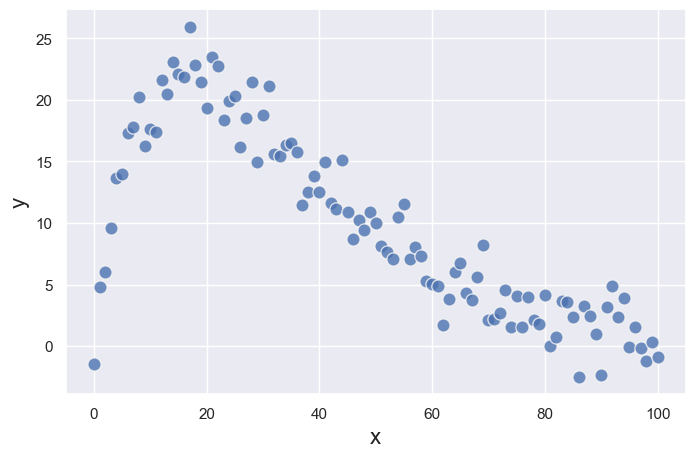

In [3]:
np.random.seed(13)
x = np.linspace(0, 100, 101)
# generating y using gamma distribution
y = (stats.gamma.pdf(x, a=2, loc=0, scale=17) + np.random.normal(0,0.002,101)) * 1000
x = x.reshape(-1,1)

plt.rcParams["figure.figsize"] = (8, 5)
plt.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.show()

initial mean guess

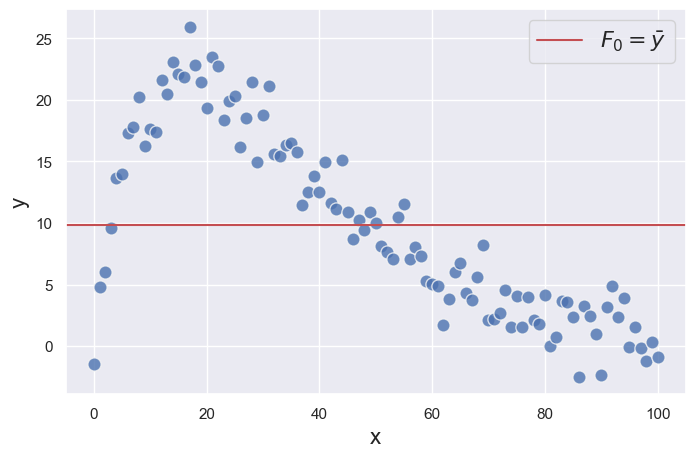

In [4]:
plt.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
plt.axhline(y=y.mean(), color='r', linestyle='-', label=r'$F_{0} = \bar{y}$')
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend(fontsize=16)
plt.show()

Plotting residuals

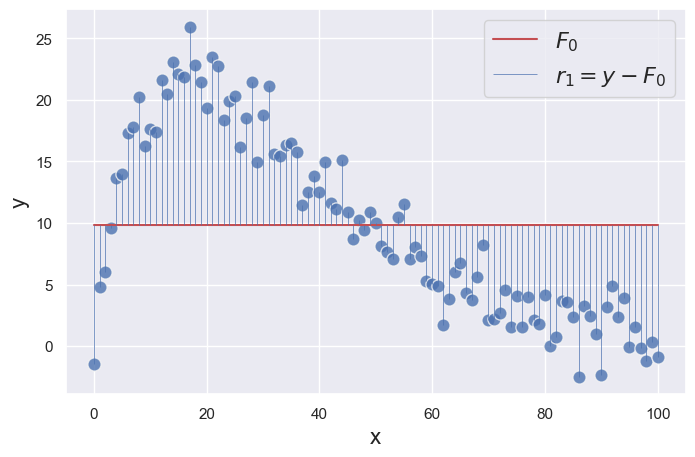

In [5]:
def plot_residuals(x, y, Fm, i, ax, title = ""):

    fltr_smaller = y < Fm
    fltr_bigger = y >= Fm

    ax.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
    ax.plot(x, Fm, c='r', label=f'$F_{i}$')
    ax.vlines(x[fltr_smaller], y[fltr_smaller], Fm[fltr_smaller], linewidth=0.5, color='b', label=f'$r_{i+1} = y - F_{i}$')
    ax.vlines(x[fltr_bigger], Fm[fltr_bigger], y[fltr_bigger], linewidth=0.5, color='b')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('x', fontsize=16)
    ax.set_ylabel('y', fontsize=16)
    ax.legend(fontsize=16)

fig, ax = plt.subplots(1, 1)
F0 = np.full(len(y), y.mean())
plot_residuals(x, y, F0, 0, ax)
plt.show()

Fitting first tree to residuals (lr set to 0.9 to exaggerate and show difference)
</br>
We use stumps with two terminal nodes and one split first to visualize results more clearly

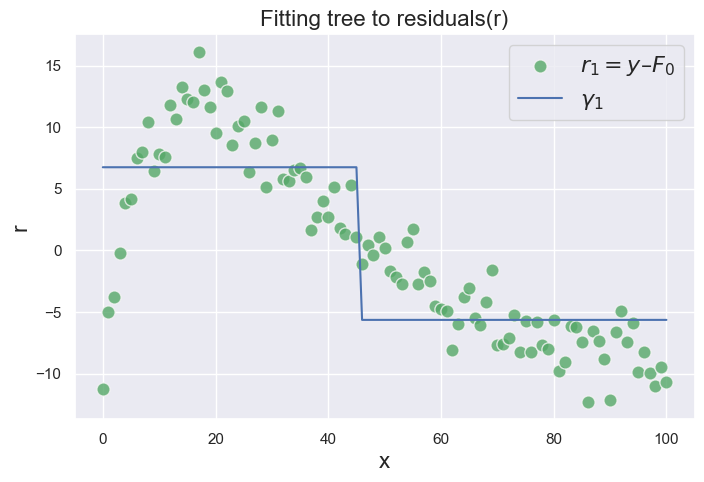

In [6]:
def train_and_update(x, y, Fm, learing_rate=0.1):
    r = y - Fm
    tree = DecisionTreeRegressor(max_depth=1, random_state=0)
    tree.fit(x, r)
    gamma = tree.predict(x)
    Fm = Fm + learing_rate * gamma
    return tree, Fm, gamma, r


def plot_gamma(x, residuals, gamma, i, ax, title = ""):

    ax.scatter(x, residuals, edgecolors='whitesmoke', color = 'g', s=90, alpha=0.8, label=f'$r_{i} = y – F_{i-1}$')
    ax.plot(x, gamma, c='b', label=f'$γ_{i}$')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("x", fontsize=16)
    ax.set_ylabel("r", fontsize=16)
    ax.legend(fontsize=16)

tree, Fm, gamma, r = train_and_update(x, y, F0, learing_rate=0.9)

fig, ax = plt.subplots(1, 1)
plot_gamma(x, r, gamma, 1, ax, "Fitting tree to residuals(r)")
plt.show()

Prediction γ₁ (scaled down by v to reduce overfitting) is added to our initial prediction F₀ to reduce the residuals
$$F₁ = F₀ + ν∙γ₁$$

Difference between before and after

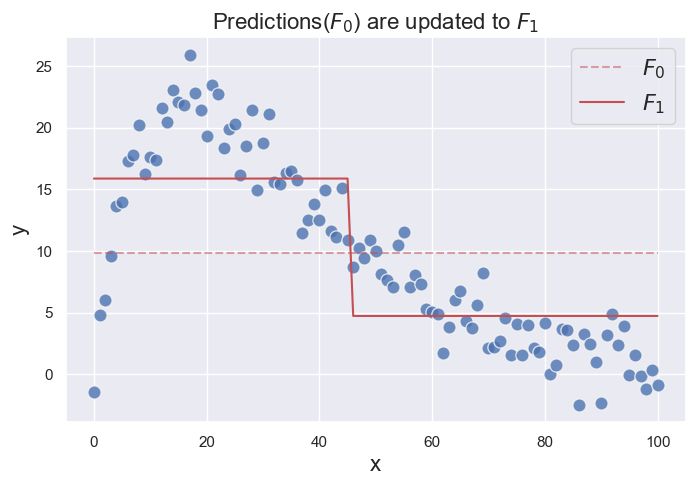

In [7]:
def plot_update(x, y, Fm, Fm_pre, i):

    plt.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
    plt.plot(x, Fm_pre, c='r', linestyle='--', label=f'$F_{i-1}$', alpha=0.5)
    plt.plot(x, Fm, c='r', label=f'$F_{i}$')
    plt.title(f"Predictions($F_{i-1}$) are updated to $F_{i}$", fontsize=16)
    plt.xlabel("x", fontsize=16)
    plt.ylabel("y", fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

plot_update(x, y, Fm, F0, 1)

New residuals

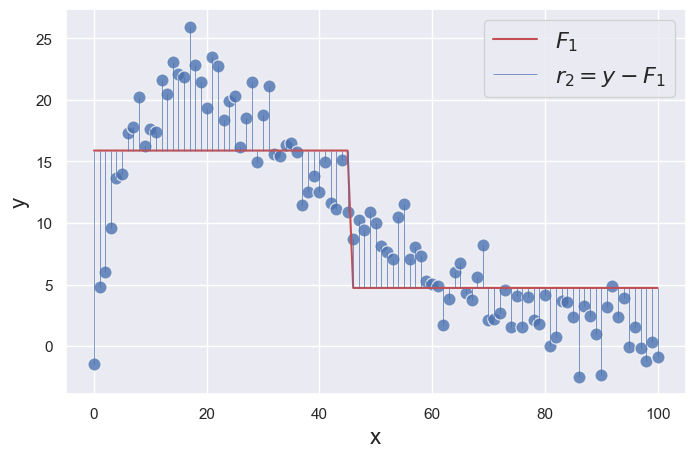

In [8]:
fig, ax = plt.subplots(1, 1)
plot_residuals(x, y, Fm, 1, ax)
plt.show()

Refit trees to new residuals

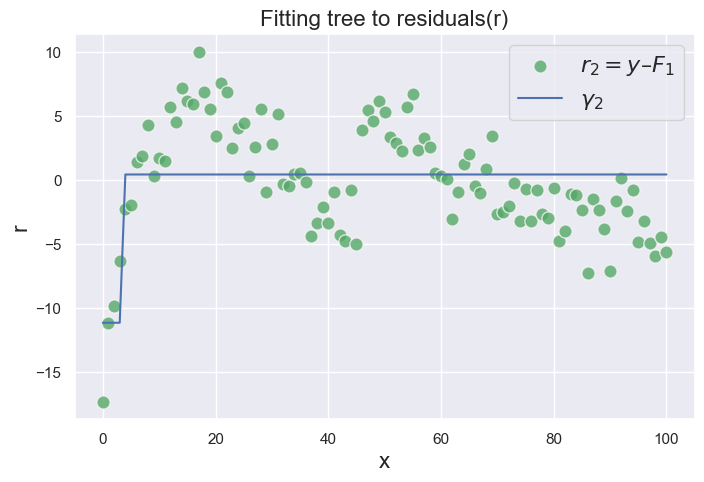

In [9]:
Fm_pre = Fm.copy()
tree, Fm, gamma, r = train_and_update(x, y, Fm, learing_rate=0.9)

fig, ax = plt.subplots(1, 1)
plot_gamma(x, r, gamma, 2, ax, "Fitting tree to residuals(r)")
plt.show()

New updated predictions

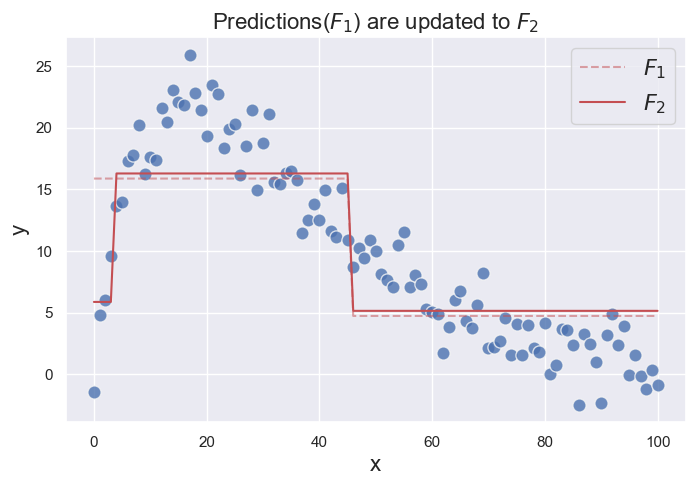

In [10]:
plot_update(x, y, Fm, Fm_pre, 2)

Fitting on 8 different iterations (Increased iterations -> Increased chance of overfitting)

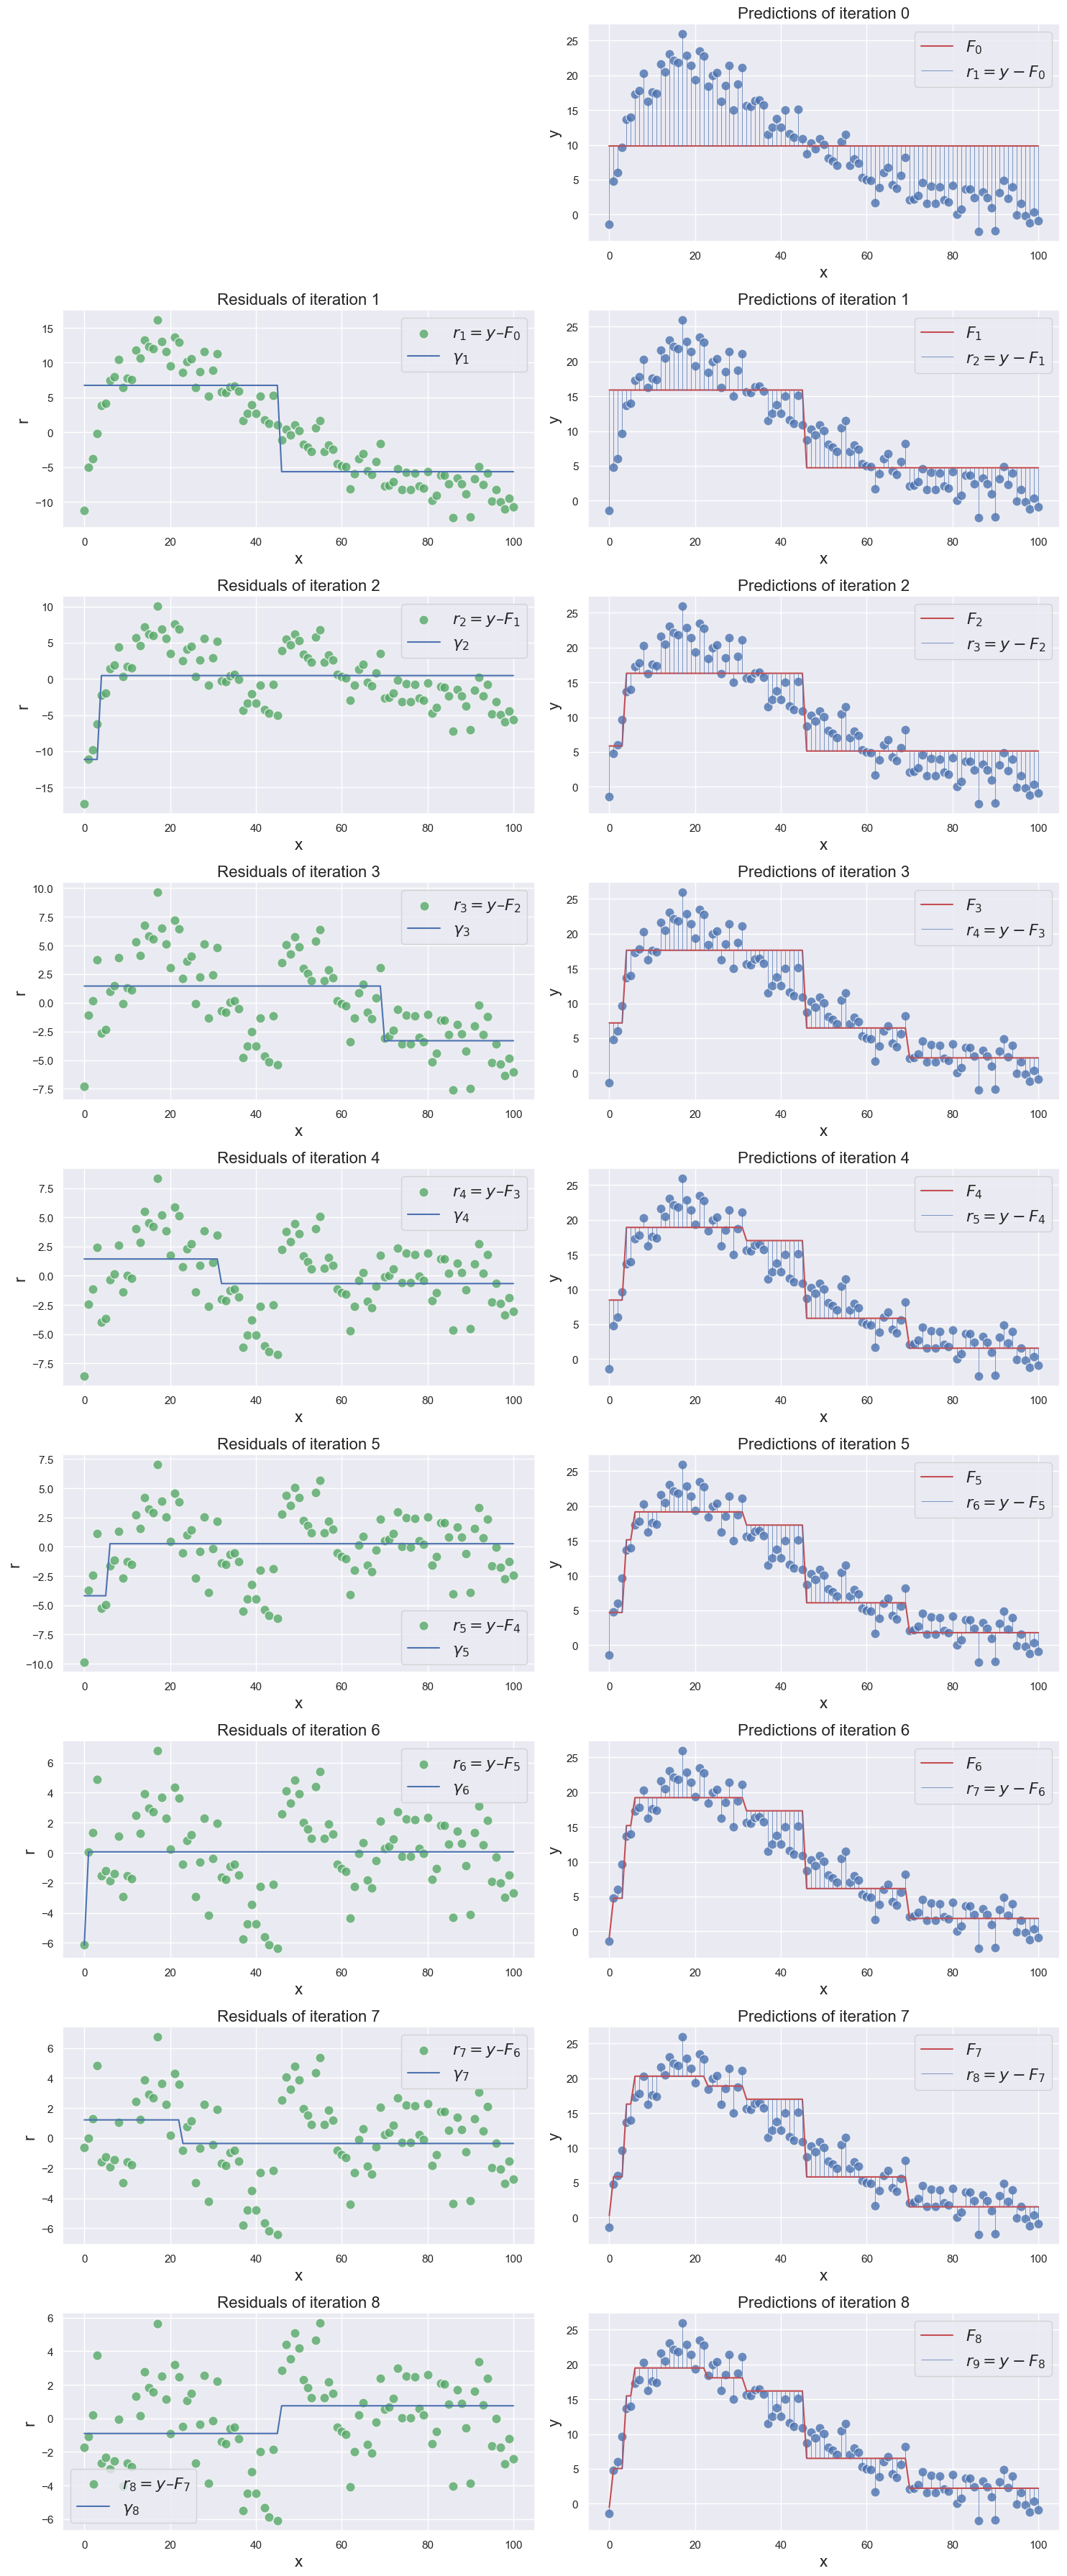

In [11]:
Fm = F0 = np.full(len(y), y.mean())
n_estimators = 8

fig, axs = plt.subplots(n_estimators+1, 2, figsize=(15, 4*(n_estimators+1)))
axs = axs.flatten()
axs[0].axis('off')

plot_residuals(x, y, F0, 0, axs[1], title="Predictions of iteration 0")

for i in range(n_estimators):
    tree, Fm, gamma, r = train_and_update(x, y, Fm, learing_rate=0.9)

    j = 2 + i*2
    plot_gamma(x, r, gamma, i+1, axs[j], f"Residuals of iteration {i+1}")
    plot_residuals(x, y, Fm, i+1, axs[j+1], title=f"Predictions of iteration {i+1}")

plt.tight_layout()
plt.show()

Comparing RMSE of custom gradient booster method vs sklearn's regression gradient boosting method to validate our method

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

custom_gbm = CustomGradientBoostingRegressor(
    n_estimators=20,
    learning_rate=0.1,
    max_depth=1
)
custom_gbm.fit(x, y)
custom_gbm_rmse = mean_squared_error(y, custom_gbm.predict(x), squared=False)
print(f"Custom GBM RMSE:{custom_gbm_rmse:.15f}")

sklearn_gbm = GradientBoostingRegressor(
    n_estimators=20,
    learning_rate=0.1,
    max_depth=1
)
sklearn_gbm.fit(x, y)
sklearn_gbm_rmse = mean_squared_error(y, sklearn_gbm.predict(x), squared=False)
print(f"Scikit-learn GBM RMSE:{sklearn_gbm_rmse:.15f}")

Custom GBM RMSE:3.625382358986911
Scikit-learn GBM RMSE:3.625382358986911


c:\Users\elsto\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\elsto\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Training on sklearn diabetes dataset

In [13]:
diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target

In [14]:
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)

In [15]:
df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13
)

In [17]:
diabetes.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [18]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = GradientBoostingRegressor(**params)

In [19]:
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 3176.5663


Testing on custom gradient boosting regressor (with deeper trees than in the first part)

In [20]:
customgbr = CustomGradientBoostingRegressor(
    n_estimators=params["n_estimators"],
    learning_rate=params["learning_rate"],
    max_depth=params["max_depth"],
)

In [21]:
customgbr.fit(X_train, y_train)

mse = mean_squared_error(y_test, customgbr.predict(X_test))
print(f"Mean squared error (MSE) on test set: {mse:.4f}")
print(f"Root mean squared error (RMSE) on test set: {mse**0.5:.4f}")

Mean squared error (MSE) on test set: 3026.5850
Root mean squared error (RMSE) on test set: 55.0144


Target range is 25 - 346 interpreted as disease progression one year after baseline therefore a standard deviation of 55 in residuals is not too bad

Looking at feature importances and permutation importance since impurity-based feature importances can be misleading for high cardinality features

C:\Users\elsto\AppData\Local\Temp\ipykernel_11152\1369224809.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T, vert=False, **tick_labels_dict)


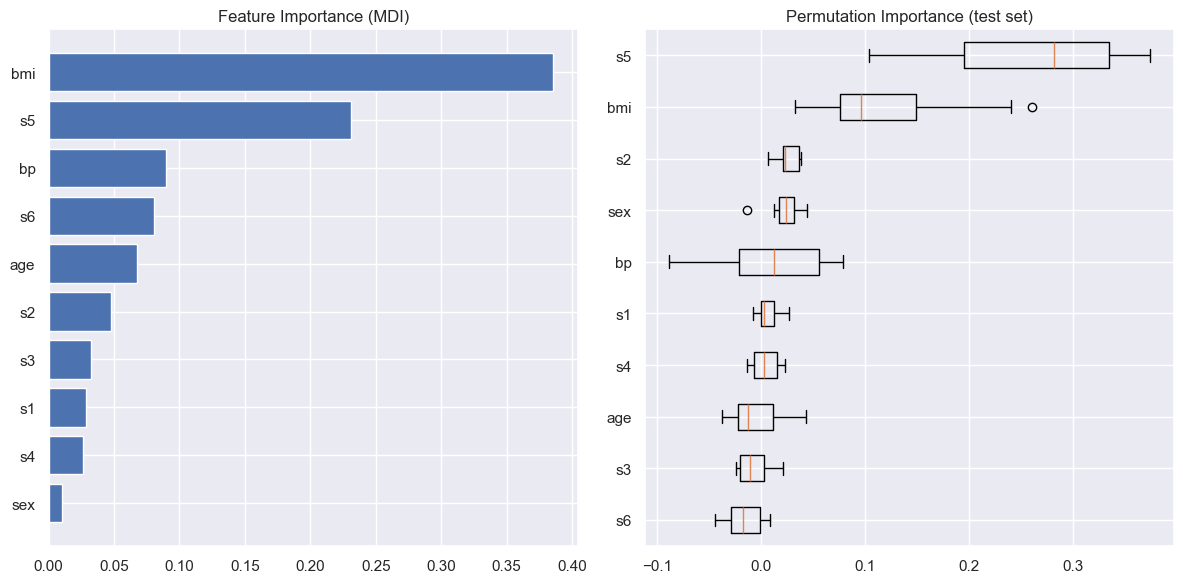

In [22]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(diabetes.feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)

tick_labels_dict = {
    'labels': np.array(diabetes.feature_names)[sorted_idx]
}
plt.boxplot(result.importances[sorted_idx].T, vert=False, **tick_labels_dict)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

From the permutation importance graph we can see that s5 (log of serum triglycerides level) has the most correlation with target prediction, followed by BMI